# Libraries

In [1]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import random
from copy import deepcopy

import numpy as np
import scipy
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions.normal import Normal
from tqdm.auto import tqdm

from timestep_sampling import Uniform, LogitNormal, UShaped
from solvers import euler, midpoint, heun, rk4
from utils import seed_everything
from model import FlowModel2D
from distances import l2_dist

In [2]:
RANDOM_SEED = 0

seed_everything(RANDOM_SEED)

# Model

# Data distribution

In [3]:
seed_everything(RANDOM_SEED)

In [4]:
n_samples = 1000

In [5]:
def create_two_moons(n_samples=1000, noise=0.05, shift=0):    
    x = torch.linspace(-1, 1, n_samples // 2)
    
    y1 = -torch.sqrt(1 - x ** 2) + np.random.normal(0, noise, n_samples // 2).astype(np.float32)
    
    y2 = torch.sqrt(1 - x ** 2) + np.random.normal(0, noise, n_samples // 2).astype(np.float32)
    
    X = torch.stack([x - shift, y1], dim=-1) * 3
    Y = torch.stack([x + shift, y2], dim=-1) * 3
    
    return X, Y

In [6]:
def create_eight_gaussians(num_samples, scale=2):
    num_samples_per_gaussian = num_samples // 8
    
    gaussian_1 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_1[:, 0] += 5
    
    gaussian_2 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_2[:, 0] -= 5
    
    gaussian_3 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_3[:, 1] += 5
    
    gaussian_4 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_4[:, 1] -= 5
    
    gaussian_5 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_5[:, 0] += ((5 + 5) ** 0.5)
    gaussian_5[:, 1] += ((5 + 5) ** 0.5)
    
    gaussian_6 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_6[:, 0] -= ((5 + 5) ** 0.5)
    gaussian_6[:, 1] -= ((5 + 5) ** 0.5)
    
    gaussian_7 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_7[:, 0] -= ((5 + 5) ** 0.5)
    gaussian_7[:, 1] += ((5 + 5) ** 0.5)
    
    gaussian_8 = torch.randn((num_samples_per_gaussian, 2))  / scale
    gaussian_8[:, 0] += ((5 + 5) ** 0.5)
    gaussian_8[:, 1] -= ((5 + 5) ** 0.5)
    
    gaussians = torch.cat([
        gaussian_1, gaussian_2, gaussian_3, gaussian_4, 
        gaussian_5, gaussian_6, gaussian_7, gaussian_8
    ])

    return gaussians

/var/folders/ky/sbwdz6j51638cf4231bcrsrr0000gn/T/ipykernel_27478/2684244310.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y1 = -torch.sqrt(1 - x ** 2) + np.random.normal(0, noise, n_samples // 2).astype(np.float32)
/var/folders/ky/sbwdz6j51638cf4231bcrsrr0000gn/T/ipykernel_27478/2684244310.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y2 = torch.sqrt(1 - x ** 2) + np.random.normal(0, noise, n_samples // 2).astype(np.float32)


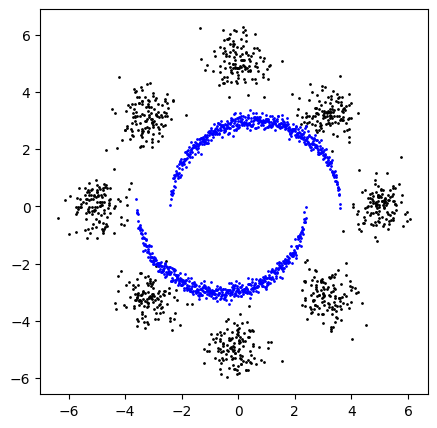

In [7]:
x_0_dataset = create_eight_gaussians(num_samples=n_samples)

top_moom, bottom_moon = create_two_moons(n_samples=n_samples, shift=0.2)
x_1_dataset = torch.cat([top_moom, bottom_moon])

fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0_dataset[:, 0], x_0_dataset[:, 1], c="Black", s=1)
plt.scatter(x_1_dataset[:, 0], x_1_dataset[:, 1], c="Blue", s=1)

# Ordinary Rectified Flow

In [8]:
eps = 1e-2

In [9]:
seed_everything(RANDOM_SEED)

In [10]:
batch_size = 256
n_epochs = 10_000

## Initialize model

In [11]:
reflow_model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    reflow_model.parameters(),
    1e-3,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [12]:
losses = []

reflow_model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = Normal(
        loc=(t * x_1 + (1 - t) * x_0), 
        scale=(eps * t * (1 - t) * torch.ones_like(x_1))
    ).sample()

    target = (x_1 - x_t) / (1 - t)

    output = reflow_model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

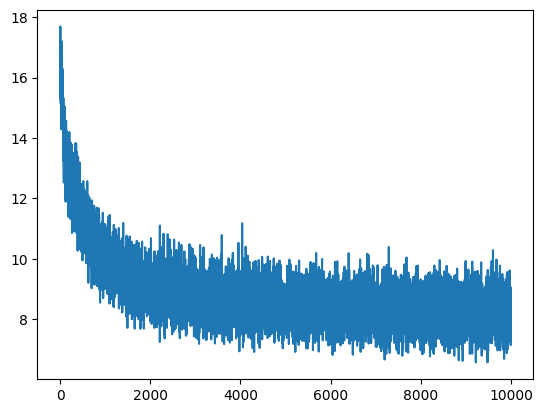

In [13]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [14]:
reflow_model.eval()

x_0 = create_eight_gaussians(num_samples=n_samples)

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

i = 0
for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        if i == NFE - 1:
          x_t = x_t + (1 / NFE) * reflow_model(x_t, t)
        else:
          z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
          x_t = x_t + (1 / NFE) * reflow_model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t

    i += 1
    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

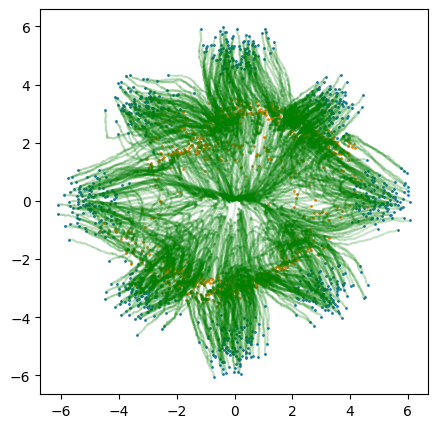

In [15]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

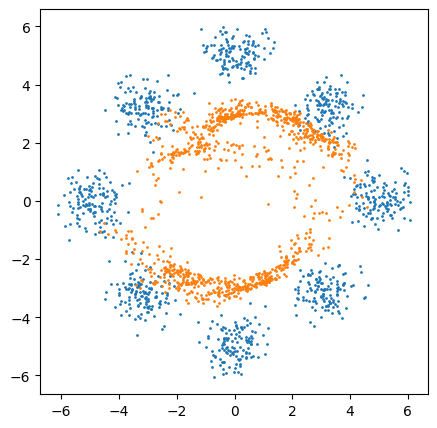

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)


# Now let's add minibatch OT

In [17]:
seed_everything(RANDOM_SEED)

In [18]:
batch_size = 256
n_epochs = 10_000

In [19]:
ot_reflow_model = FlowModel2D(2, 16, 2)

optimizer = torch.optim.AdamW(
    ot_reflow_model.parameters(),
    1e-3,
)

loss_function = torch.nn.MSELoss()

## Random Sampling

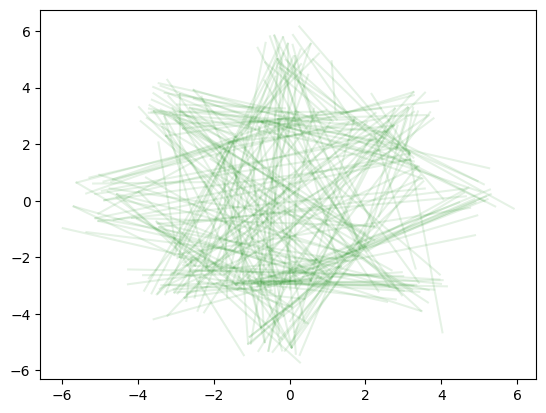

In [20]:
x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

for i in range(batch_size):
    plt.plot(
        [x_0[i, 0].item(), x_1[i, 0].item()], 
        [x_0[i, 1].item(), x_1[i, 1].item()], 
        c="Green",
        alpha=0.1
    )

plt.show()

## OT Sampling

In [21]:
x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

dist = l2_dist(x_0, x_1).numpy()
row_ind, col_ind = scipy.optimize.linear_sum_assignment(dist)
x_1 = x_1[col_ind]

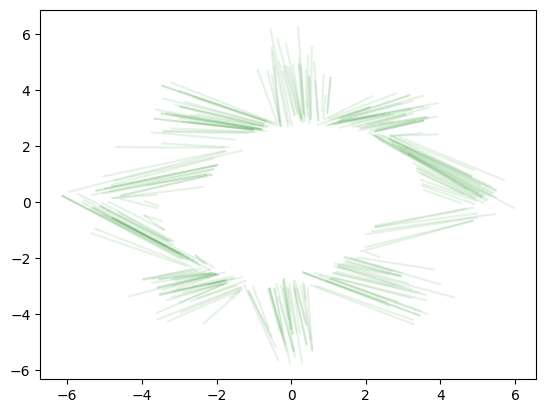

In [22]:
for i in range(batch_size):
    plt.plot(
        [x_0[i, 0].item(), x_1[i, 0].item()], 
        [x_0[i, 1].item(), x_1[i, 1].item()], 
        c="Green",
        alpha=0.1
    )

plt.show()

## Let's train

In [23]:
losses = []

ot_reflow_model.train()
for i in tqdm(range(n_epochs)):
    x_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    x_1 = x_1_dataset[torch.randint(0, n_samples, (batch_size,))]

    dist = l2_dist(x_0, x_1)
    plan = scipy.optimize.linear_sum_assignment(dist)[1]
    x_1 = x_1[plan]
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    x_t = Normal(
        loc=(t * x_1 + (1 - t) * x_0), 
        scale=(eps * t * (1 - t) * torch.ones_like(x_1))
    ).sample()

    target = (x_1 - x_t) / (1 - t)

    output = ot_reflow_model(x_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/10000 [00:00<?, ?it/s]

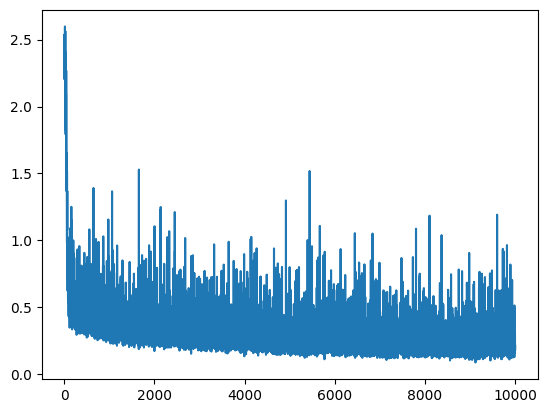

In [24]:
plt.plot(list(range(n_epochs)), losses)

In [25]:
ot_reflow_model.eval()

x_0 = create_eight_gaussians(num_samples=n_samples)

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

i = 0
for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        if i == NFE - 1:
          x_t = x_t + (1 / NFE) * ot_reflow_model(x_t, t)
        else:
          z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
          x_t = x_t + (1 / NFE) * ot_reflow_model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t

    i += 1
    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

## Inference

  0%|          | 0/1000 [00:00<?, ?it/s]

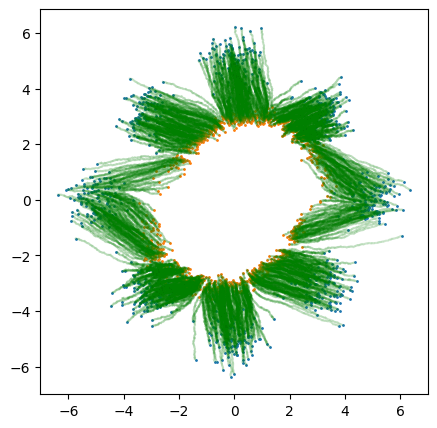

In [26]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step - 1, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

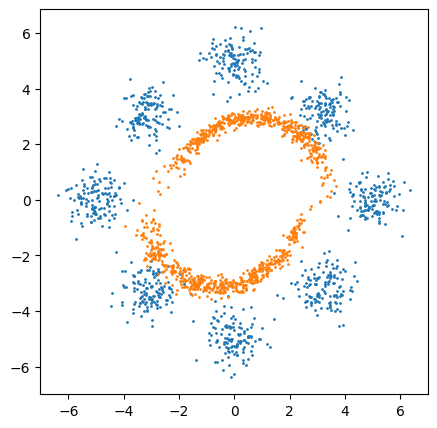

In [27]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)


# Reflow 2 from Reflow 1

In [28]:
seed_everything(RANDOM_SEED)

In [29]:
batch_size = 256
n_epochs = 1_000

In [30]:
teacher_model = deepcopy(reflow_model)
reflow_2_model = deepcopy(reflow_model)

optimizer = torch.optim.AdamW(
    reflow_2_model.parameters(),
    1e-3,
)

loss_function = torch.nn.MSELoss()

In [31]:
def teacher_sample_z_1(model, x_0):
    model.eval()
    x_t = x_0.clone()

    NFE = 100
    h = 1 / NFE
    
    for t in torch.linspace(0, 1, NFE):
        t = torch.full(size=(x_0.shape[0], 1), fill_value=t)
        
        with torch.no_grad():
            if i == NFE - 1:
              x_t = x_t + (1 / NFE) * model(x_t, t)
            else:
              z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
              x_t = x_t + (1 / NFE) * model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t
    
    return x_t

## Let's train

In [32]:
losses = []

reflow_2_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    z_t = Normal(
        loc=(t * z_1 + (1 - t) * z_0), 
        scale=(eps * t * (1 - t) * torch.ones_like(z_1))
    ).sample()

    target = (z_1 - z_t) / (1 - t)

    output = reflow_2_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

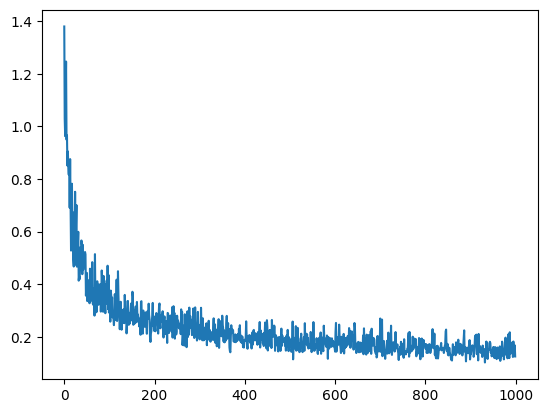

In [33]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [34]:
reflow_2_model.eval()

x_0 = create_eight_gaussians(num_samples=n_samples)

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        if i == NFE - 1:
          x_t = x_t + (1 / NFE) * reflow_2_model(x_t, t)
        else:
          z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
          x_t = x_t + (1 / NFE) * reflow_2_model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

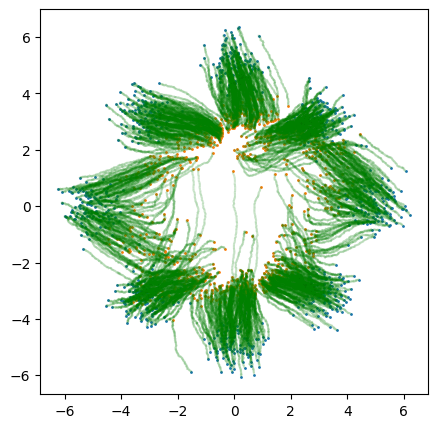

In [35]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

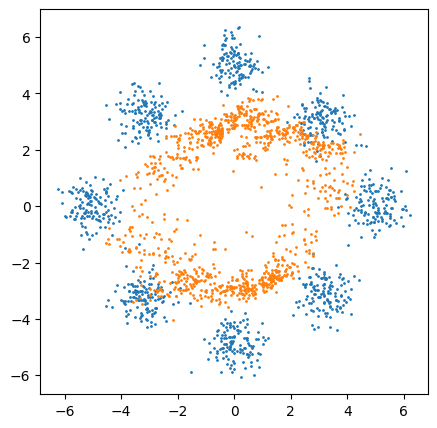

In [36]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

# Reflow 2 form OT Reflow 1

In [37]:
seed_everything(RANDOM_SEED)

In [38]:
batch_size = 256
n_epochs = 1_000

In [39]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [40]:
losses = []

ot_reflow_2_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = torch.sigmoid(torch.randn((batch_size, 1)))

    z_t = Normal(
        loc=(t * z_1 + (1 - t) * z_0), 
        scale=(eps * t * (1 - t) * torch.ones_like(z_1))
    ).sample()

    target = (z_1 - z_t) / (1 - t)
    
    output = ot_reflow_2_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

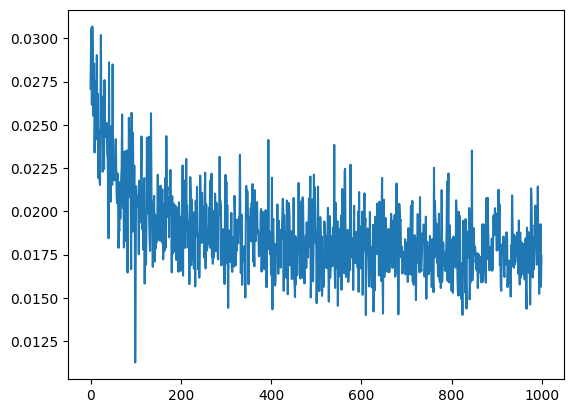

In [41]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [42]:
ot_reflow_2_model.eval()

x_0 = create_eight_gaussians(num_samples=n_samples)

x_t = x_0.clone()
x_ts = [x_t]

NFE = 100
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        if i == NFE - 1:
            x_t = x_t + (1 / NFE) * ot_reflow_2_model(x_t, t)
        else:
            z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
            x_t = x_t + (1 / NFE) * ot_reflow_2_model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t

    x_ts.append(x_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

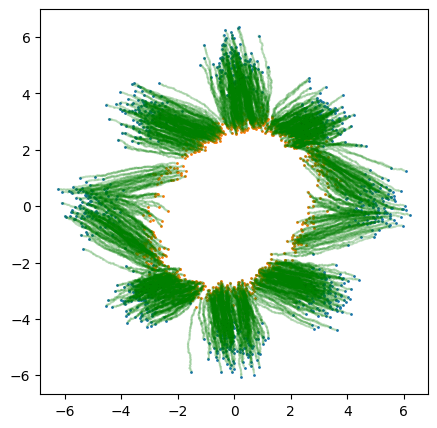

In [43]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()

# U-shaped Timestep Distribution

In [44]:
seed_everything(RANDOM_SEED)

In [45]:
batch_size = 256
n_epochs = 1_000

In [46]:
ushaped_dist = UShaped(a=4)

In [47]:
teacher_model = deepcopy(ot_reflow_model)
ot_reflow_2_u_model = deepcopy(ot_reflow_model)

optimizer = torch.optim.AdamW(
    ot_reflow_2_u_model.parameters(),
    5e-4,
)

loss_function = torch.nn.MSELoss()

## Let's train

In [48]:
losses = []

ot_reflow_2_u_model.train()
for i in tqdm(range(n_epochs)):
    z_0 = x_0_dataset[torch.randint(0, n_samples, (batch_size,))]
    z_1 = teacher_sample_z_1(teacher_model, z_0)
    
    t = ushaped_dist.sample(batch_size).unsqueeze(dim=1)

    z_t = Normal(
        loc=(t * z_1 + (1 - t) * z_0), 
        scale=(eps * t * (1 - t) * torch.ones_like(z_1))
    ).sample()

    target = (z_1 - z_t) / (1 - t)

    output = ot_reflow_2_u_model(z_t, t)

    loss = loss_function(output, target)

    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

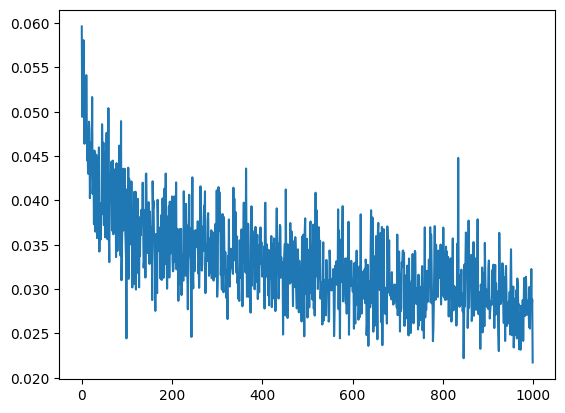

In [49]:
plt.plot(list(range(n_epochs)), losses)

## Inference

In [50]:
ot_reflow_2_u_model.eval()

x_0 = create_eight_gaussians(num_samples=n_samples)

x_t = x_0.clone()
x_ts = [x_t]

NFE = 5
h = 1 / NFE

for t in tqdm(torch.linspace(0, 1, NFE)):
    t = torch.full(size=(n_samples, 1), fill_value=t)
    
    with torch.no_grad():
        if i == NFE - 1:
            x_t = x_t + (1 / NFE) * ot_reflow_2_u_model(x_t, t)
        else:
            z_t = Normal(torch.zeros_like(x_0), torch.ones_like(x_0)).sample()
            x_t = x_t + (1 / NFE) * ot_reflow_2_u_model(x_t, t) + torch.sqrt(torch.tensor((eps / NFE), dtype=torch.float32)) * z_t

    x_ts.append(x_t)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

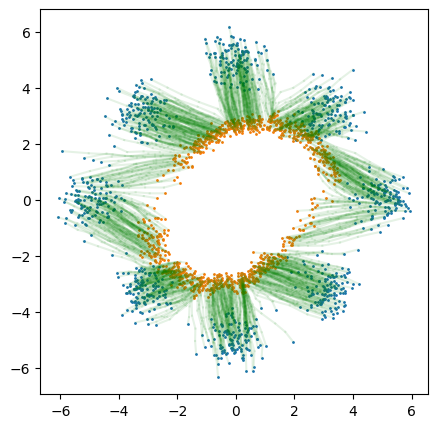

In [51]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(x_0[:, 0], x_0[:, 1], s=1)
plt.scatter(x_t[:, 0], x_t[:, 1], s=1)

step = 1

for sample_i in tqdm(range(n_samples)):
    for t in range(0, len(x_ts) - step, step):
        plt.plot(
            [x_ts[t][sample_i, 0].item(), x_ts[t + step][sample_i, 0].item()], 
            [x_ts[t][sample_i, 1].item(), x_ts[t + step][sample_i, 1].item()], 
            c="Green",
            alpha=0.1
        )
        
plt.show()